In [1]:
# Start orekit
import orekit
from math import radians, degrees
import matplotlib.pyplot as plt
orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

In [4]:
# import necessary libraries
from org.orekit.frames import FramesFactory
from org.orekit.orbits import KeplerianOrbit
from org.orekit.orbits import PositionAngle
from org.orekit.propagation import SpacecraftState
from org.orekit.propagation.analytical import KeplerianPropagator
from org.orekit.time import AbsoluteDate
from org.orekit.time import TimeScalesFactory

# import the numerial propagator libraries
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.orbits import OrbitType
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.forces.gravity import ThirdBodyAttraction
from org.orekit.utils import IERSConventions

from org.orekit.forces.radiation import SolarRadiationPressure
from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient

from org.orekit.bodies import CelestialBodyFactory

from org.orekit.propagation.sampling import OrekitFixedStepHandler
from org.orekit.python import PythonOrekitFixedStepHandler



In [18]:
from org.orekit.attitudes import AttitudeProvider;
from org.orekit.attitudes import AttitudesSequence;
from org.orekit.attitudes import LofOffset;
from org.orekit.bodies import CelestialBodyFactory;
from org.orekit.errors import OrekitException;
from org.orekit.frames import FramesFactory;
from org.orekit.frames import LOFType;
from org.orekit.orbits import KeplerianOrbit;
from org.orekit.orbits import Orbit;
from org.orekit.propagation import Propagator;
from org.orekit.propagation import SpacecraftState;
from org.orekit.propagation.analytical import EcksteinHechlerPropagator;
from org.orekit.propagation.events import EclipseDetector;
from org.orekit.propagation.events import EventDetector;
from org.orekit.propagation.events.handlers import EventHandler;
from org.orekit.propagation.sampling import OrekitFixedStepHandler;
from org.orekit.time import AbsoluteDate;
from org.orekit.time import TimeScalesFactory;
from org.orekit.utils import Constants;
from org.orekit.utils import PVCoordinates;
from org.orekit.utils import PVCoordinatesProvider;

In [5]:
# Set the initial State of the spacecraft
a = 24396159.0    # semi major axis (m)
e = 0.720  # eccentricity
i = radians(10.0) # inclination
omega = radians(50.0) # perigee argument
raan = radians(150.0) #right ascension of ascending node
lM = 0.0 # mean anomaly

# Set inertial frame
inertialFrame = FramesFactory.getEME2000()

# Initial date in UTC time scale
utc = TimeScalesFactory.getUTC()
initialDate = AbsoluteDate(2016, 1, 1, 5, 30, 00.00, utc)  # year, month, day, hours,mintues, seconds

# Setup orbit propagator
#gravitation coefficient
mu = 3.986004415e+14

# Orbit construction as Keplerian
initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lM,
                              PositionAngle.MEAN, inertialFrame,
                              initialDate, mu)

initialstate = SpacecraftState(initialOrbit)

In [6]:
def simple_keplarian(initialOrbit, initialDate):
    """
    :param initialOrbit: initial Keplarian orbit and central body
    :param initialDate: intial start date
    :return: plot xy orbit
    """

    # Simple extrapolation with Keplerian motion
    kepler = KeplerianPropagator(initialOrbit)
    # Set the propagator to slave mode (could be omitted as it is the default mode)
    kepler.setSlaveMode()
    # Setup propagation time
    # Overall duration in seconds for extrapolation
    duration = 24 * 60.0 ** 2
    # Stop date
    finalDate = AbsoluteDate(initialDate, duration, utc)
    # Step duration in seconds
    stepT = 30.0
    # Perform propagation
    # Extrapolation loop
    cpt = 1.0
    extrapDate = initialDate
    px, py = [], []
    while extrapDate.compareTo(finalDate) <= 0:
        currentState = kepler.propagate(extrapDate)
        print('step {}: time {} {}\n'.format(cpt, currentState.getDate(), currentState.getOrbit()))
        coord = currentState.getPVCoordinates().getPosition()
        px.append(coord.getX())
        py.append(coord.getY())
        # P[:,cpt]=[coord.getX coord.getY coord.getZ]
        extrapDate = AbsoluteDate(extrapDate, stepT, utc)
        cpt += 1
    plt.plot(px, py)
    plt.show()

In [7]:
initialDate.shiftedBy(1000.0)

<AbsoluteDate: 2016-01-01T05:46:40.000>

In [11]:
# use a numerical propogator and integrator
min_step = 0.001
max_step = 1000.0
position_tolerance = 10.0

propagation_type = OrbitType.KEPLERIAN
tolerances = NumericalPropagator.tolerances(position_tolerance, initialOrbit,
                                            propagation_type)

integrator = DormandPrince853Integrator(min_step, max_step, 1e-4, 1e-5)

propagator = NumericalPropagator(integrator)
propagator.setOrbitType(propagation_type)

In [38]:
class TutorialStepHandler(PythonOrekitFixedStepHandler):

    def init(self,s0, t):
        print('Orbial Elements')
    
    def handleStep(self, currentState, isLast):
        print('Step handler')
        o = OrbitType.KEPLERIAN.convertType(currentState.getOrbit())
        print({12}o.getA()," ", o.getE())
#         print("%s %:12.3f %:10.8f %:106f %:10.6f %:10.6f %:10.6f".format(currentState.getDate(), o.getA(), o.getE(),
#                                                                       o.getI(),o.getPerigeeArgument(),
#                                                                       o.getRightAscensionOfAscendingNode(),
#                                                                       o.getTrueAnomaly()))
        if isLast:
            print('this was the last step ')

In [31]:
# force model gravity field
provider = GravityFieldFactory.getNormalizedProvider(10, 10)
holmesFeatherstone = HolmesFeatherstoneAttractionModel(FramesFactory.getITRF(IERSConventions.IERS_2010, True), provider)

# Add Earth, Moon, and Sun body gravity field
propagator.addForceModel(holmesFeatherstone)
propagator.addForceModel(ThirdBodyAttraction(CelestialBodyFactory.getSun()))
propagator.addForceModel(ThirdBodyAttraction(CelestialBodyFactory.getMoon()))

# SRP
ssc = IsotropicRadiationSingleCoefficient(100.0, 0.8)   # Spacecraft surface area (m^2), C_r absorbtion 
spr = SolarRadiationPressure(CelestialBodyFactory.getSun(), a, ssc)   # sun, semi-major Earth, spacecraft sensitivity

# propagator.addForceModel(spr)


In [39]:
handler = mystephandler()
propagator.setMasterMode(60.0, TutorialStepHandler())

propagator.setInitialState(initialstate)

finalState = propagator.propagate(initialDate.shiftedBy(1000.0))    # TIme shift in seconds

o = OrbitType.KEPLERIAN.convertType(finalState.getOrbit())

print('Final State: date: {}\na: {} \ne: {} \ni:{} \ntheta {}'.format(
       finalState.getDate(), o.getA(), o.getE(), degrees(o.getI()), degrees(o.getLv())))

print("done")

Orbial Elements
Step handler
(24396159.0, ' ', 0.72)
Step handler
(24390504.757832676, ' ', 0.7199309497827369)
Step handler
(24381624.19889462, ' ', 0.7198168503962477)
Step handler
(24369904.716292698, ' ', 0.7196628043630096)
Step handler
(24355777.994995534, ' ', 0.7194746878135146)
Step handler
(24339759.138516493, ' ', 0.7192595436251775)
Step handler
(24322434.795298148, ' ', 0.7190253466503255)
Step handler
(24304409.32724594, ' ', 0.7187802707239856)
Step handler
(24286227.908840045, ' ', 0.7185317045904628)
Step handler
(24268332.856684666, ' ', 0.7182856919149149)
Step handler
(24251047.68171857, ' ', 0.7180467265938667)
Step handler
(24234584.87501531, ' ', 0.7178178503748684)
Step handler
(24219067.330819868, ' ', 0.7176009224981847)
Step handler
(24204549.812173825, ' ', 0.7173968919868888)
Step handler
(24191039.15021064, ' ', 0.7172060551402968)
Step handler
(24178511.546767455, ' ', 0.7170282773985677)
Step handler
(24166925.34995957, ' ', 0.7168631587462879)
this was 

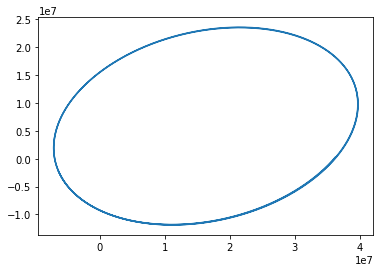

In [9]:
duration = 24 * 60.0 ** 2
# Stop date
finalDate = AbsoluteDate(initialDate, duration, utc)
# Step duration in seconds
stepT = 30.0
# Perform propagation
# Extrapolation loop
cpt = 1.0
px = []
py = []
extrapDate = initialDate
while extrapDate.compareTo(finalDate) <= 0:
    currentState = propagator.propagate(extrapDate)
    # print('step {}: time {} {}\n'.format(cpt, currentState.getDate(), currentState.getOrbit()))
    coord = currentState.getPVCoordinates().getPosition()
    px.append(coord.getX())
    py.append(coord.getY())
    # P[:,cpt]=[coord.getX coord.getY coord.getZ]
    extrapDate = AbsoluteDate(extrapDate, stepT, utc)
    
plt.plot(px,py)
plt.show()